In [1]:
import mne
import os
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [2]:
#project directories
project_dir = os.getcwd()
os.chdir(project_dir)
mne.set_config('SUBJECTS_DIR',os.path.join(project_dir,'recons'))
data_dir = os.path.join(project_dir, 'rawMEGdata')
rawfile = os.path.join(data_dir,'subj04NN_sess01_raw_tsss.fif')
results_dir = os.path.join(project_dir,'results')

In [3]:
# read epochs
epochs = mne.read_epochs('data_tmp\\subj_{}-epo.fif'.format(0), preload=True)

# read noise covariance
noise_cov = mne.read_cov('data_tmp\\subj_{}-noise-cov.fif'.format(0))

Reading f:\MYPROJECTS16\project_demoMNEpython\data_tmp\subj_0-epo.fif ...
    Read a total of 2 projection items:
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) active
        EOG-axial--0.200-0.200-PCA-01 (1 x 102) active
    Found the data of interest:
        t =    -200.00 ...     796.00 ms
        0 CTF compensation matrices available
Not setting metadata
418 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 2)
2 projection items activated
    306 x 306 full covariance (kind = 1) found.
    Read a total of 2 projection items:
        EOG-planar--0.200-0.200-PCA-01 (1 x 204) active
        EOG-axial--0.200-0.200-PCA-01 (1 x 102) active


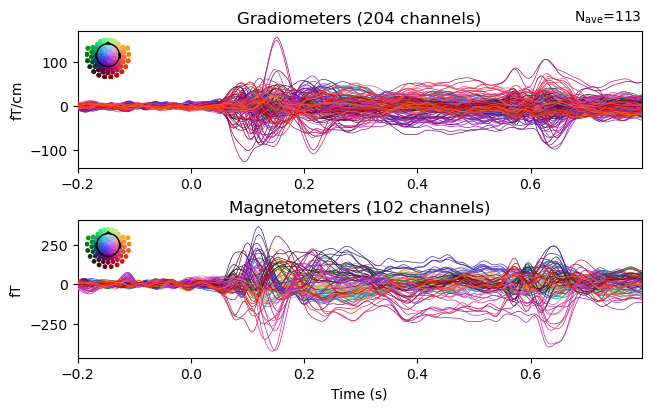

In [5]:
# compute evoked response
evoked = epochs[['human/face','animal/face']].average()
evoked.plot(show=False)
plt.show()

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 2.8e-13 (2.2e-16 eps * 306 dim * 4.1  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.8e-13 (2.2e-16 eps * 306 dim * 4.1  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
SSS has been applied to data. Showing mag and grad whitening jointly.
    Created an SSP operator (subspace dimension = 2)
Computing rank from covariance with rank={'meg': 304}


C:\Users\pantazis\AppData\Local\Temp\ipykernel_53872\2915194072.py:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov,time_unit='s', show=False)
C:\Users\pantazis\AppData\Local\Temp\ipykernel_53872\2915194072.py:2: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  evoked.plot_white(noise_cov,time_unit='s', show=False)


    Setting small MEG eigenvalues to zero (without PCA)
    Created the whitener using a noise covariance matrix with rank 304 (2 small eigenvalues omitted)


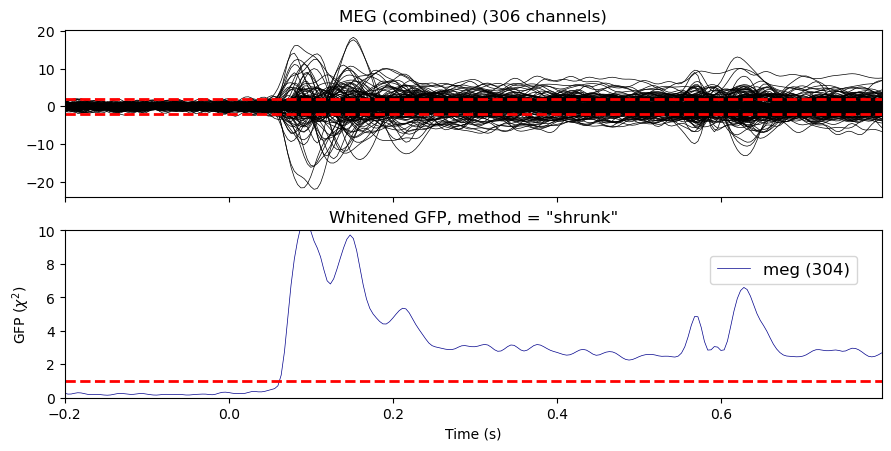

In [6]:
# plot whitened evoked response
evoked.plot_white(noise_cov,time_unit='s', show=False)
plt.show() 

In [7]:
# read forward solution
fwd = mne.read_forward_solution(os.path.join(project_dir,'data_tmp\\subj_{}-fwd.fif'.format(0)))

Reading forward solution from f:\MYPROJECTS16\project_demoMNEpython\data_tmp\subj_0-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (8195 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame


In [8]:
# inverse operator
# notice loose=0 means orientation constrain normal to the cortex; loose non-zero allows the orientation to vary
inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7793/8195 = 10.003567
    scale = 4.60382e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 2)
Computing rank from covariance with rank=None
    Using tolerance 2.8e-13 (2.2e-16 eps * 306 dim * 4.1  max singular value)
    Estimated rank (mag + grad): 304
    MEG: rank 304 computed from 306 data channels with 2 projectors
    Setting small MEG eigenvalues to zero (without PCA)


C:\Users\pantazis\AppData\Local\Temp\ipykernel_53872\1062424736.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)
C:\Users\pantazis\AppData\Local\Temp\ipykernel_53872\1062424736.py:3: RuntimeWarning: Something went wrong in the data-driven estimation of the data rank as it exceeds the theoretical rank from the info (304 > 69). Consider setting rank to "auto" or setting it explicitly as an integer.
  inv = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, noise_cov, loose=0.2, depth=0.8)


Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 16.3661
    scaling factor to adjust the trace = 1.88017e+22 (nchan = 306 nzero = 2)


In [9]:
# compute inverse solution (source time courses)
method = 'MNE'  #“MNE” | “dSPM” | “sLORETA” | “eLORETA”
snr = 3.
lambda2 = 1./snr ** 2
stc, residual = mne.minimum_norm.apply_inverse(evoked, inv, lambda2,
                              method=method, pick_ori=None,
                              return_residual=True, verbose=True)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 113
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 2)
    Created the whitener using a noise covariance matrix with rank 304 (2 small eigenvalues omitted)
Applying inverse operator to "0.04 × animate/human/face/13 + 0.04 × animate/human/face/14 + 0.05 × animate/human/face/15 + 0.04 × animate/human/face/16 + 0.04 × animate/human/face/17 + 0.04 × animate/human/face/18 + 0.04 × animate/human/face/19 + 0.04 × animate/human/face/20 + 0.04 × animate/human/face/21 + 0.04 × animate/human/face/22 + 0.04 × animate/human/face/23 + 0.05 × animate/human/face/24 + 0.05 × animate/animal/face/37 + 0.04 × animate/animal/face/38 + 0.04 × animate/animal/face/39 + 0.04 × animate/animal/face/40 + 0.04 × animate/animal/face/41 + 0.04 × animate/animal/face/42 + 0.04 × animate/animal/face/43 + 0.04 × animate/animal/face/44 + 0.04 × animate/animal/face/45 + 0.04 × ani

In [18]:
# plot sources on cortex
vertno_max, time_max = stc.get_peak(hemi='rh')
surfer_kwargs = dict(
    hemi='rh', views='lateral',
    initial_time=time_max, time_unit='s', size=(800, 800), smoothing_steps=10) #for colorbar limits: clim=dict(kind='value', lims=[8, 12, 15])
brain = stc.plot(**surfer_kwargs)
brain.add_text(0.1, 0.9, 'MNE solution', 'title', font_size=14)
plt.show()

Using control points [9.52485042e-13 1.10412001e-12 2.83238004e-12]


In [19]:
# Roi analysis
# read labels (regions of interest from the aparc atlas)
subjectname = 'subj04NN'
labels = mne.read_labels_from_annot(subject=subjectname,parc='aparc',hemi='both',surf_name='white',annot_fname=None)
# label time courses (one time course per label)
labels_tc = mne.extract_label_time_course(stcs=stc, labels=labels, src=inv['src'],mode='mean_flip',return_generator=True)
# label time courses (time courses of all vertices within a label)
stc_label = stc.in_label(labels[0])


Reading labels from parcellation...
   read 34 labels from f:\MYPROJECTS16\project_demoMNEpython\recons\subj04NN\label\lh.aparc.annot
   read 34 labels from f:\MYPROJECTS16\project_demoMNEpython\recons\subj04NN\label\rh.aparc.annot
Extracting time courses for 68 labels (mode: mean_flip)
